In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from collections import namedtuple

def plot_histogram(data, num_bins, bottom=None):
    plt.hist(data, bins=num_bins, bottom=bottom, color='blue', alpha=0.7)
    plt.xlabel('z value')
    plt.ylabel('Frequency')
    plt.title('Sensor calibration errors, normalised by standard deviation')

# Load data from CSV file
def load_data_from_csv(file_path):
    data = pd.read_csv(file_path)
    return data

# where to save plots
overwrite = True
save_path = "/home/luke/Documents/thesis_plots/rl_chapter/"

import sys
pathhere = "/home/luke/mujoco-devel/rl/"
sys.path.insert(0, pathhere)
from env.MjEnv import MjEnv
mjenv = MjEnv()
from TrainingManager import TrainingManager

In [2]:
# increase matplotlib resolution
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

/tmp/ipykernel_180848/300713432.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(labels)


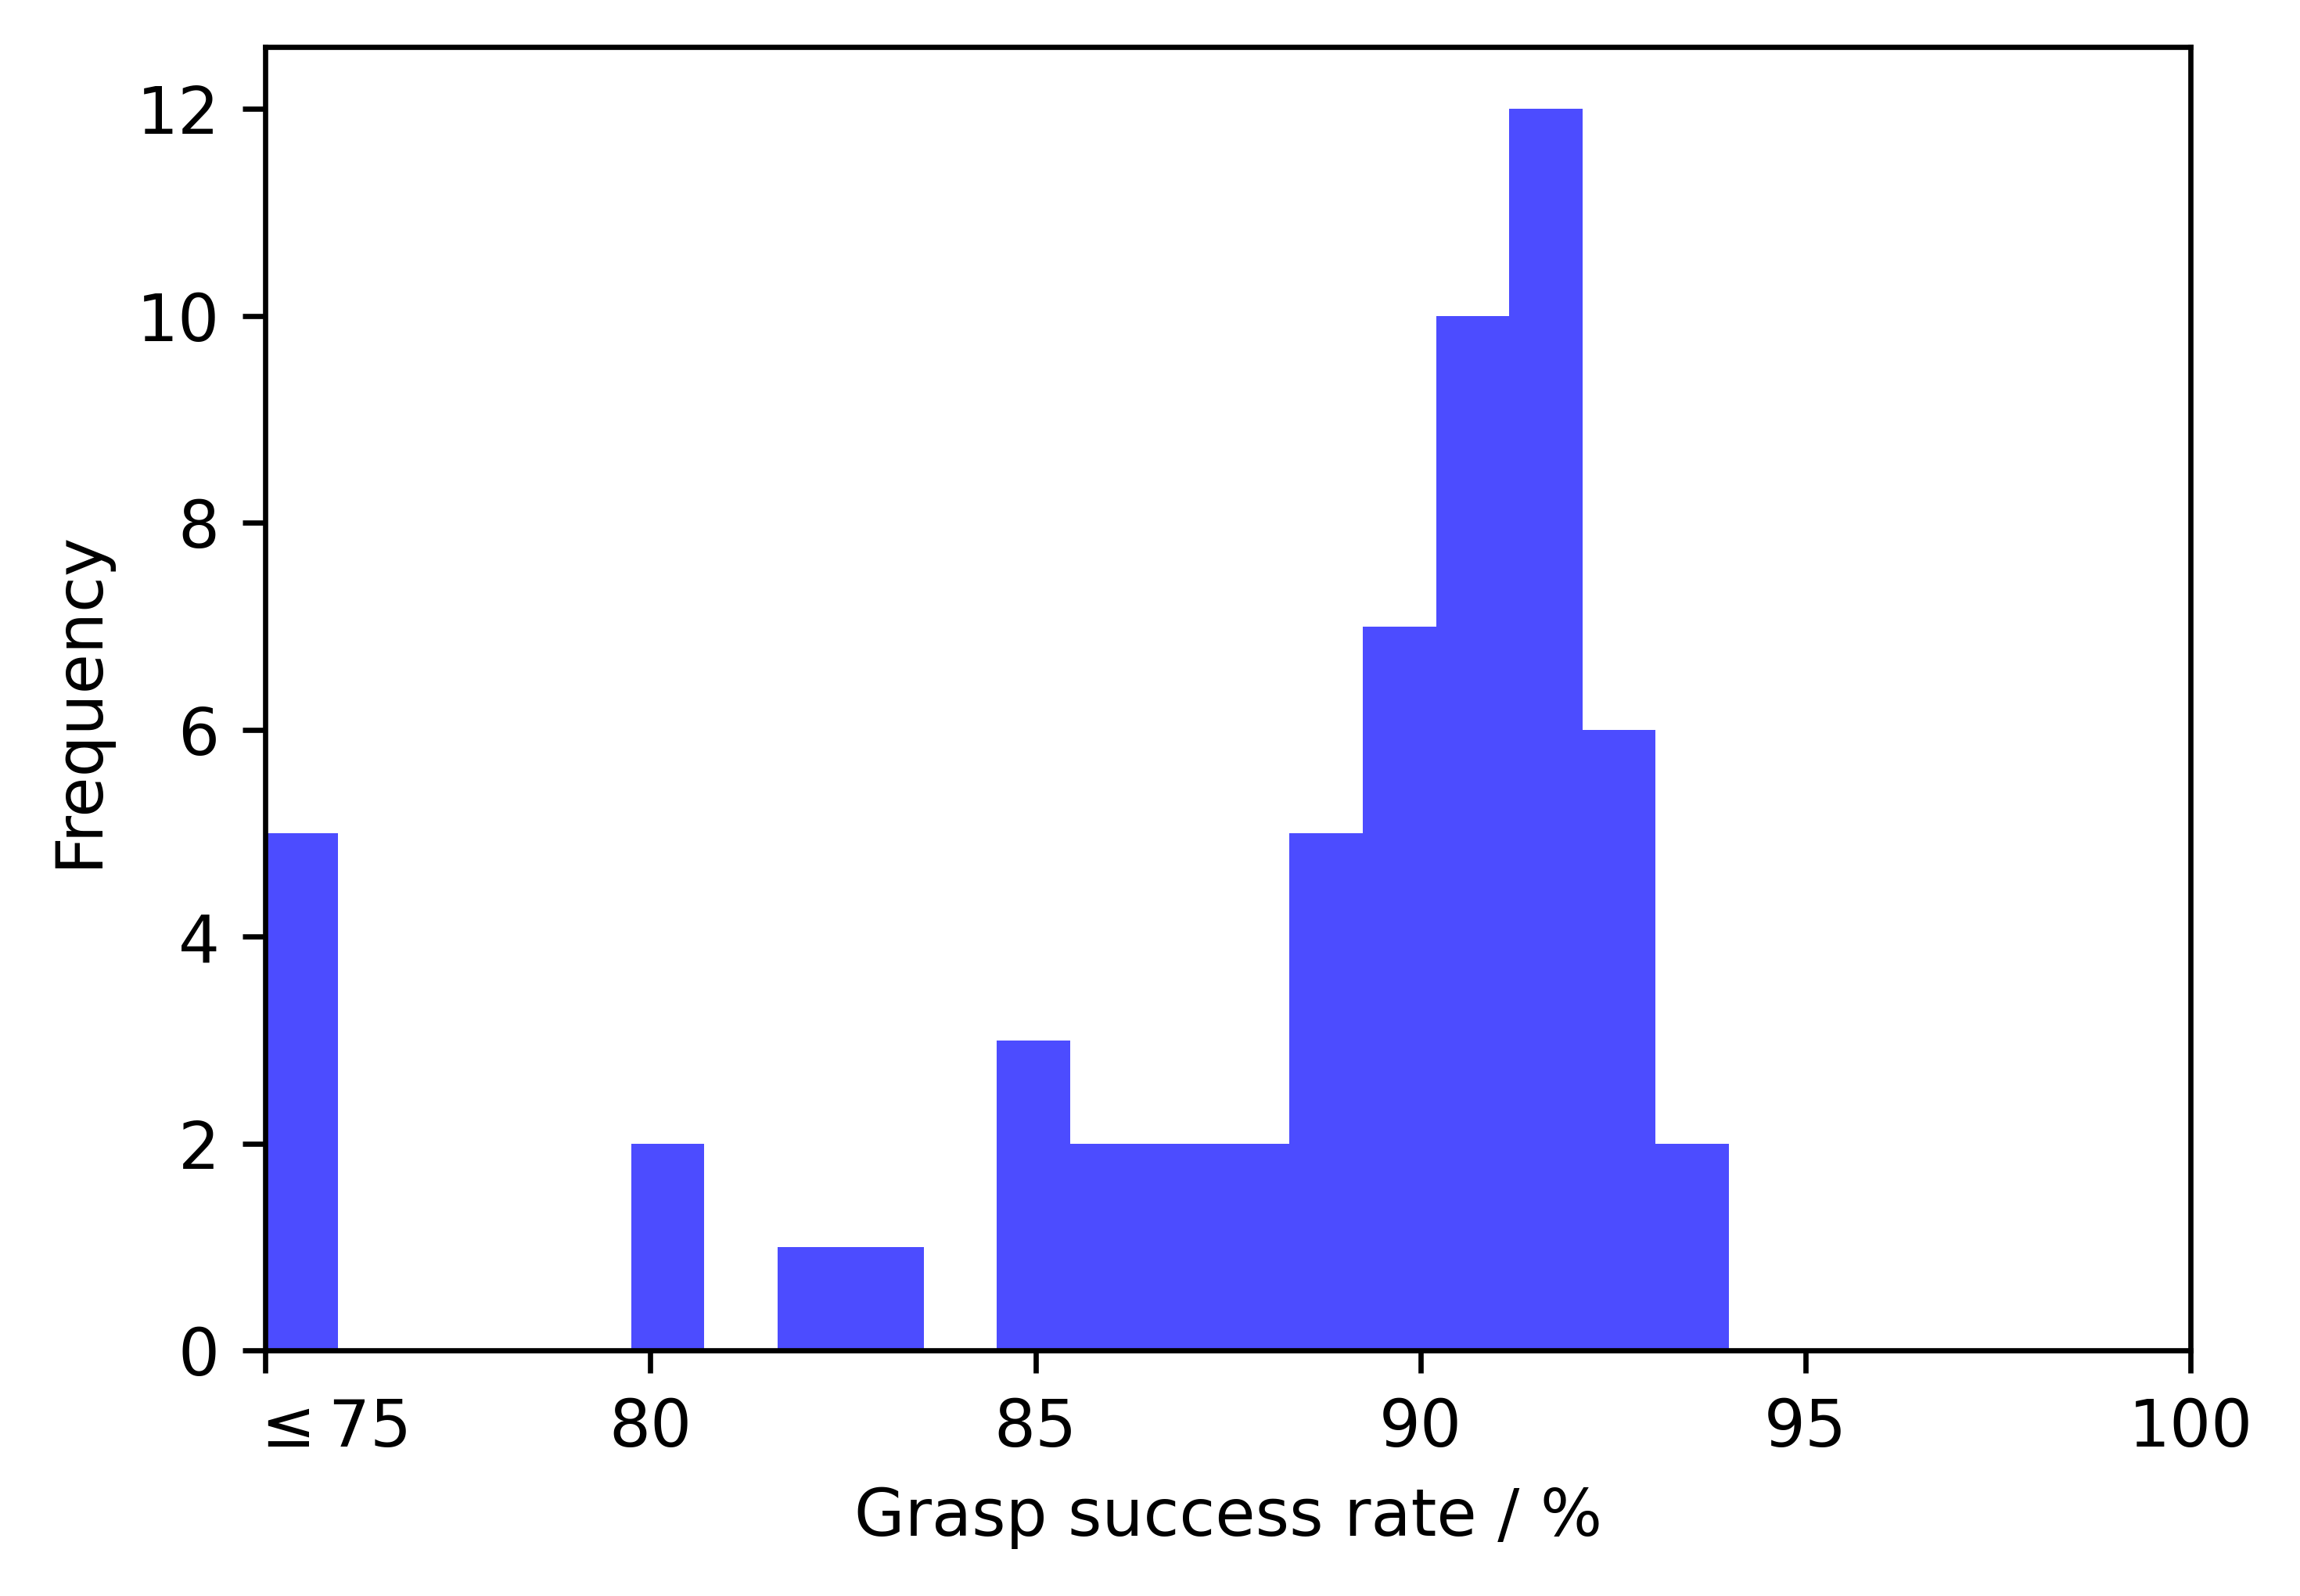

In [3]:
def plot_histogram(data, num_bins, bottom=None):
    plt.hist(data, bins=num_bins, bottom=bottom, color='blue', alpha=0.7)
    plt.xlabel('z value')
    plt.ylabel('Frequency')
    plt.title('Sensor calibration errors, normalised by standard deviation')

# Path to your CSV file (replace 'data.csv' with your file path)
csv_file_path = 'training_spread.csv'

# Load data from CSV file
data = load_data_from_csv(csv_file_path)

# Extract the column of interest (replace 'column_name' with the name of the column you want to plot)
column_name = ' set8_fullset_1500'
data_to_plot = np.array(data[column_name]) * 100
data_to_plot = np.clip(data_to_plot, 75, 100)
num_bins = 20

fig, axs = plt.subplots(1, 1)

_, bins, patches = axs.hist(data_to_plot, bins=num_bins, color="blue", alpha=0.7)
axs.set_xlabel("Grasp success rate / %")
axs.set_ylabel("Frequency")
axs.set_xlim([75, 100])

# xlabels = np.round(bins[0:].astype(float),2).astype(str)
# xlabels[0] += '+'
# N_labels = len(xlabels)

# plt.xticks(num_bins * np.arange(N_labels))
# axs.set_xticklabels(xlabels)
# axs.set_xlim([0.75, 1.0])

labels = axs.get_xticklabels()
labels[0] = r"      $\leq$75"
axs.set_xticklabels(labels)

fig.set_size_inches(5, 3.5)
fig.tight_layout()

if True and overwrite: fig.savefig(save_path + "training_spread.png")

In [4]:
import scipy.stats as stats
import math

confidence_level = 0.95
stdevs_from_mean = 1.0

probability_of_success = 1 - stats.norm.cdf(stdevs_from_mean)
n = math.ceil(math.log(1 - confidence_level) / math.log(1 - probability_of_success))

print(f"Number of runs needed to have {confidence_level*100:.0f}% confidence at least one is greater than {stdevs_from_mean} standard deviations above the mean:", n)

Number of runs needed to have 95% confidence at least one is greater than 1.0 standard deviations above the mean: 18


In [5]:
import math

n = 15  # number of runs
confidence_level = 0.95

probability_of_success = 1 - (1 - confidence_level) ** (1 / n)
stdevs_from_mean = -stats.norm.ppf(probability_of_success)

print("Probability of success:", probability_of_success)
print(f"Given {n} runs, there is {confidence_level*100:.0f}% confidence at least one is greater than {stdevs_from_mean:.2f} standard deviations above the mean")

Probability of success: 0.18103627252208465
Given 15 runs, there is 95% confidence at least one is greater than 0.91 standard deviations above the mean


In [6]:
def make_tm():
  tm = TrainingManager(log_level=0)
  tm.settings["savedir"] = "/home/luke/mujoco-devel/rl/models/"
  tm.trainer = tm.make_trainer(None, None)
  return tm

def get_jobs_from_timestamp(timestamp, run_name_prefix=None):
  """
  Find all the jobs with a particular timestamp
  """

  tm = make_tm()
  tm.set_group_run_name(job_num=1, timestamp=timestamp, prefix=run_name_prefix)
  match_str = tm.run_name[:-3]

  # get all the run folder corresponding to this timestamp
  group_path = tm.trainer.savedir + "/" + tm.group_name
  run_folders = [x for x in os.listdir(group_path) if x.startswith(match_str)]

  job_nums = []

  for folder in run_folders:
    num = folder.split(match_str)[-1][2:] # from _A5 -> 5"
    job_nums.append(int(num))

  # sort into numeric ascending order
  job_nums.sort()

  # check for failures
  if len(job_nums) == 0:
    print(f"launch_training.py warning: get_jobs_from_timestamp found zero trainings matching '{match_str}'")

  return job_nums

def load_results(timestamp, jobs=None):
  """
  Load track results for a series of trainings
  """

  tm = make_tm()
  trackdata = []

  if jobs is None:
    if not isinstance(timestamp, list):
      timestamp = [timestamp]
    for t in timestamp:
      jobs = get_jobs_from_timestamp(t)
      for j in jobs:
        # load tracking information for this training
        tm.load(job_num=j, timestamp=t, trackonly=True)
        trackdata.append(tm.trainer.track)
  else:
    for j in jobs:
      # load tracking information for this training
      tm.load(job_num=j, timestamp=timestamp, trackonly=True)
      trackdata.append(tm.trainer.track)

  return trackdata

def load_rewards_vector(timestamp, jobs=None, min_sr=-1, sort=False, name="", trim=True, printinfo=False):
  """
  Load training results into a vector, with optional filters
  """

  data = load_results(timestamp=timestamp, jobs=jobs)

  # can sort by successful grasp
  if sort:
    data = sorted(data, key=lambda x: np.max(x.avg_successful_grasp))

  # for d in data:
  #   id = np.argmax(d.avg_successful_grasp)
  #   print(d.test_rewards[id])
  # print(f"Quartiles: {np.max(data[0].avg_successful_grasp)} / {np.max(data[15].avg_successful_grasp)} / {np.max(data[30].avg_successful_grasp)} / {np.max(data[45].avg_successful_grasp)}")

  # get vectors as numpy arrays, and only count trainings that finished
  data_length = 0
  rewards = []
  for i, d in enumerate(data):
    # print(i, "length", len(d.train_avg_rewards))
    if trim:
      if np.max(d.avg_successful_grasp) < min_sr: continue
      if len(d.train_avg_rewards) > data_length:
        data_length = len(d.train_avg_rewards)
        episodes = d.train_avg_episodes
        rewards = [d.train_avg_rewards]
      elif len(d.train_avg_rewards) == data_length:
        rewards.append(d.train_avg_rewards)
    else:
      if len(d.train_avg_rewards) > data_length:
        data_length = len(d.train_avg_rewards)
        episodes = d.train_avg_episodes
        rewards.append(d.train_avg_rewards)
      else:
        rewards.append(d.train_avg_rewards)

  if printinfo:
    print(f"{name + ': ' if name != '' else ''}Number of runs used {len(rewards)} out of {len(data)}, trim = {trim}")

  return rewards, episodes

def load_test_results_vector(timestamp, jobs=None, min_sr=-1, sort=False, name="", trim=True, printinfo=False):
  """
  Load test time results into a vector, with optional filters
  """

  data = load_results(timestamp=timestamp, jobs=jobs)

  # can sort by successful grasp
  if sort:
    data = sorted(data, key=lambda x: np.max(x.avg_successful_grasp))

  # for d in data:
  #   id = np.argmax(d.avg_successful_grasp)
  #   print(d.test_rewards[id])
  # print(f"Quartiles: {np.max(data[0].avg_successful_grasp)} / {np.max(data[15].avg_successful_grasp)} / {np.max(data[30].avg_successful_grasp)} / {np.max(data[45].avg_successful_grasp)}")

  # get vectors as numpy arrays, and only count trainings that finished
  data_length = 0
  results = []
  for i, d in enumerate(data):
    # print(i, "length", len(d.test_episodes))
    if trim:
      if np.max(d.avg_successful_grasp) < min_sr: continue
      if len(d.test_episodes) > data_length:
        data_length = len(d.test_episodes)
        episodes = d.test_episodes
        results = [d.avg_successful_grasp]
      elif len(d.avg_successful_grasp) == data_length:
        results.append(d.avg_successful_grasp)
    else:
      if len(d.test_episodes) > data_length:
        data_length = len(d.test_episodes)
        episodes = d.test_episodes
        results.append(d.avg_successful_grasp)
      else:
        results.append(d.avg_successful_grasp)

  if printinfo:
    print(f"{name + ': ' if name != '' else ''}Number of runs used {len(results)} out of {len(data)}, trim = {trim}")

  return results, episodes

def tolerant_mean(arrs):
    # find mean of vectors of different lengths, without zero padding
    # from: https://stackoverflow.com/questions/10058227/calculating-mean-of-arrays-with-different-lengths
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

def tolerant_max(arrs):
    # find mean of vectors of different lengths, without zero padding
    # from: https://stackoverflow.com/questions/10058227/calculating-mean-of-arrays-with-different-lengths
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.max(axis = -1)

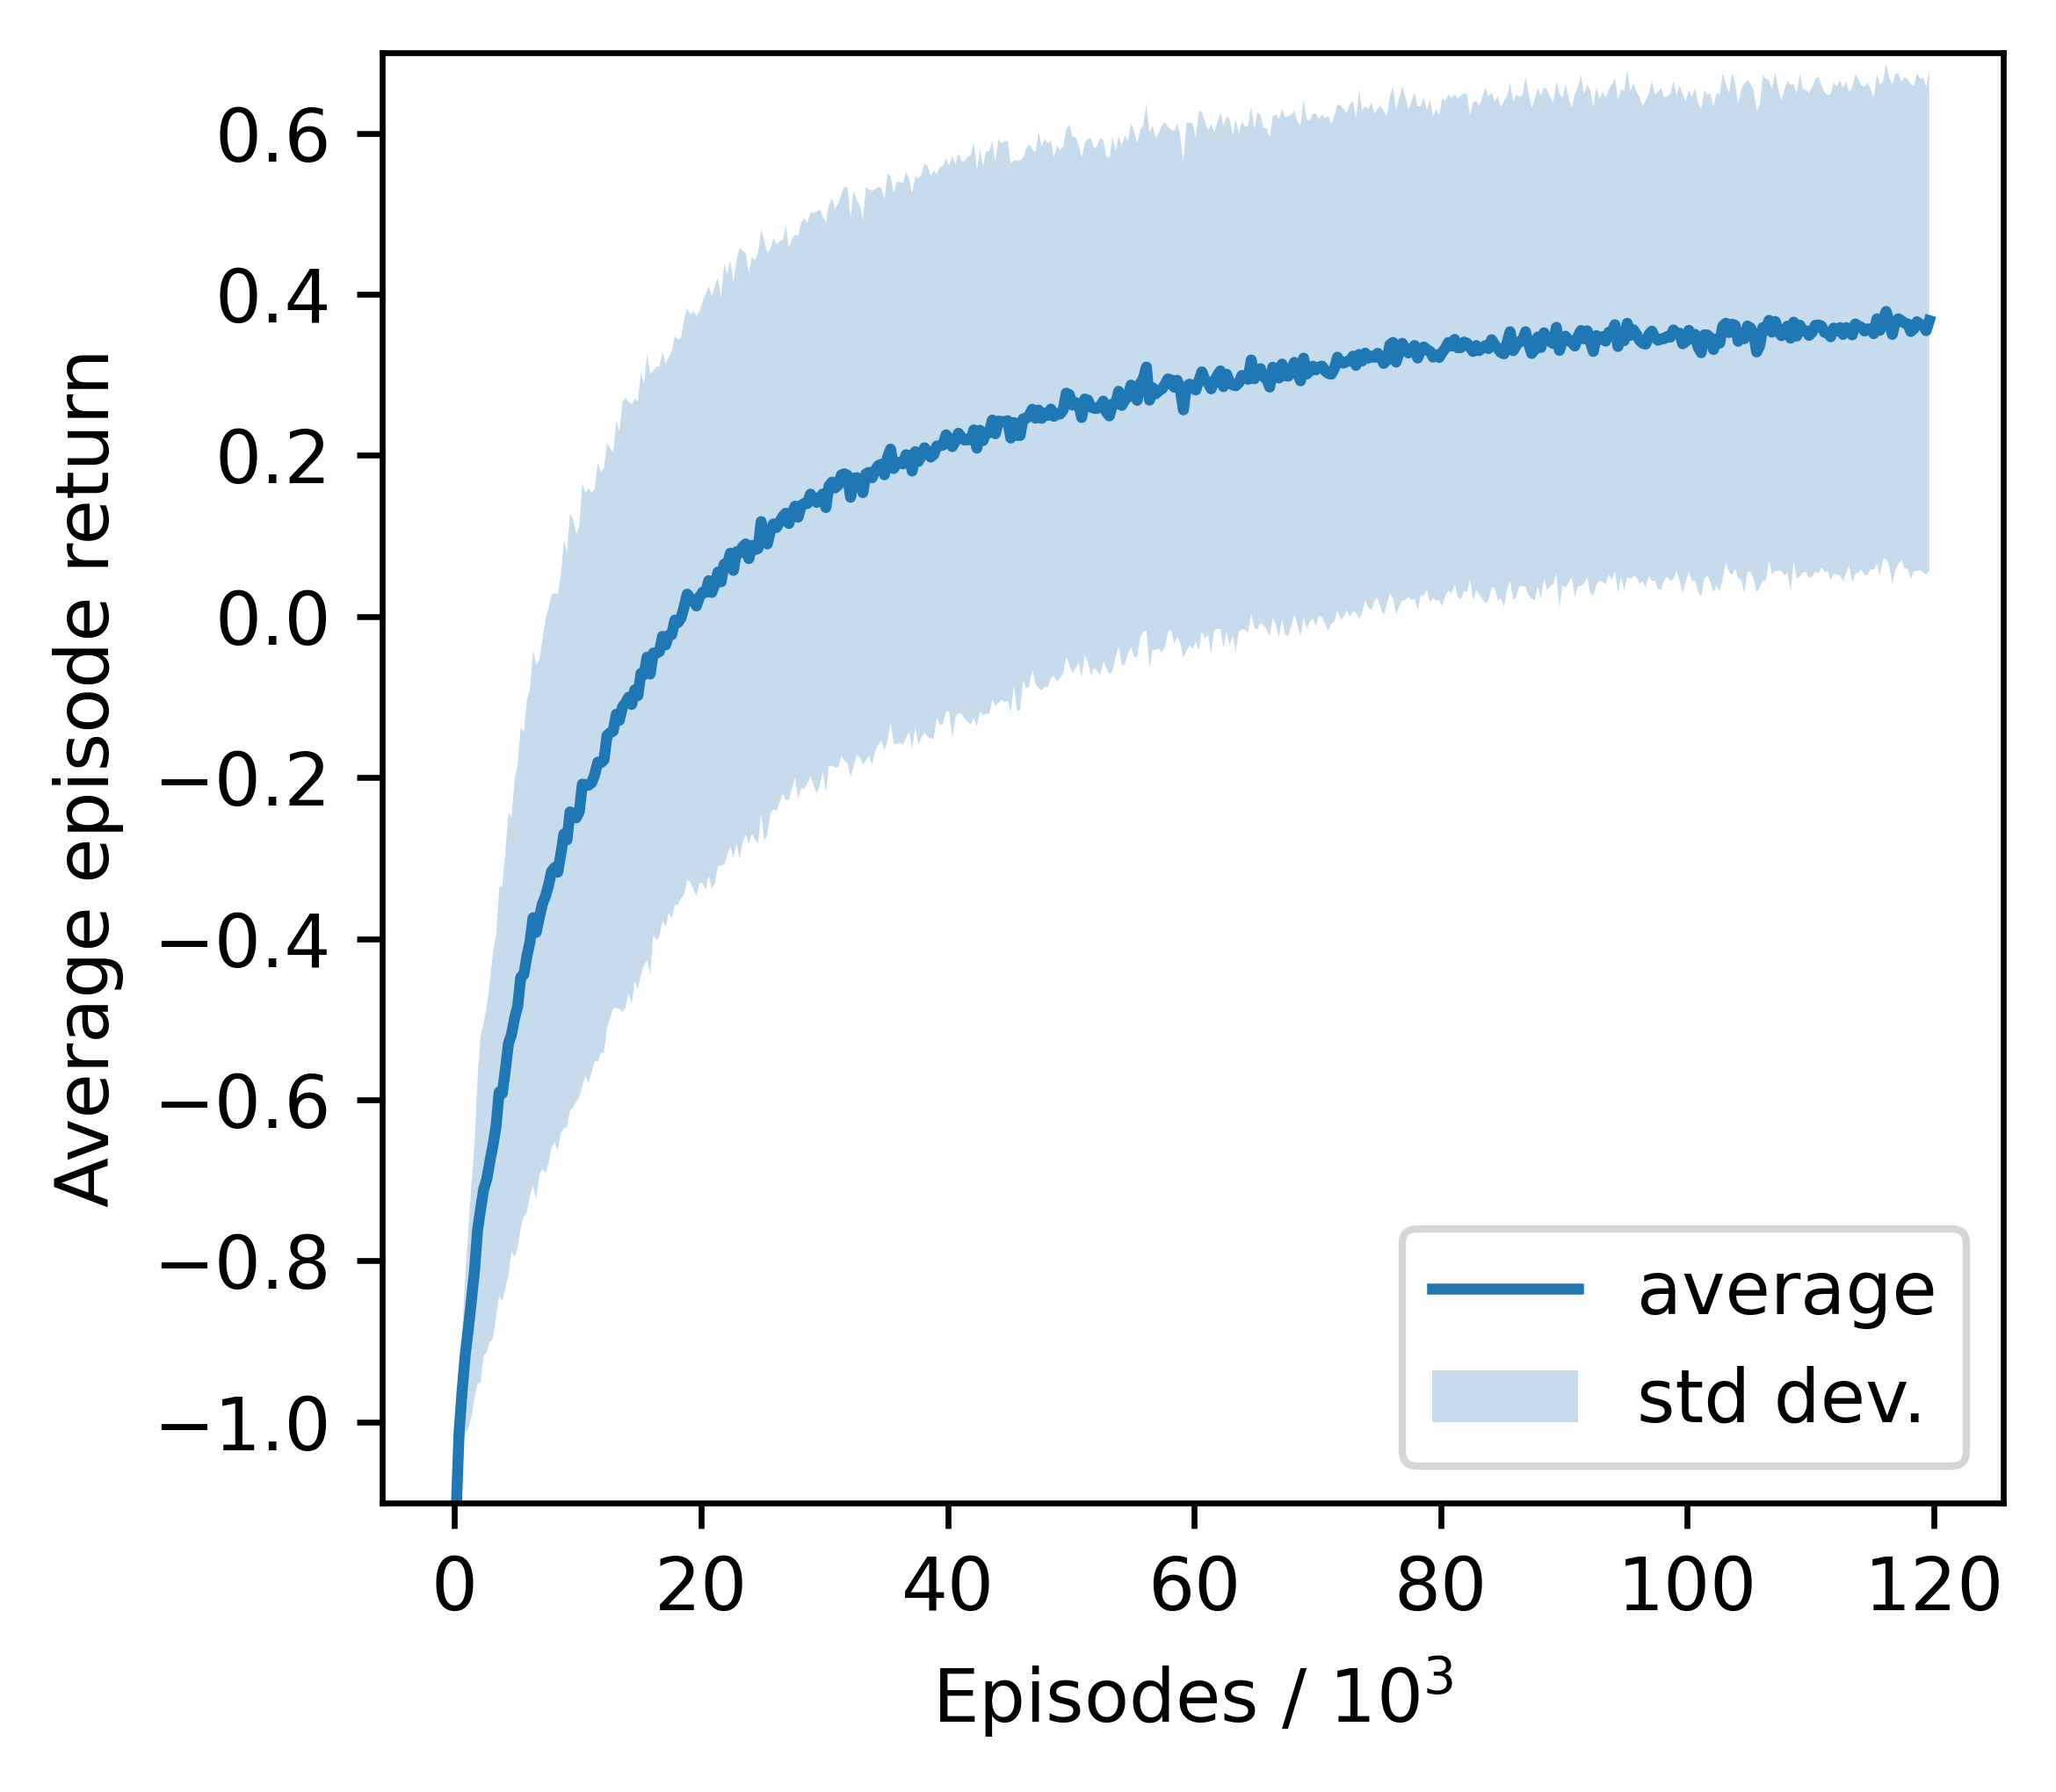

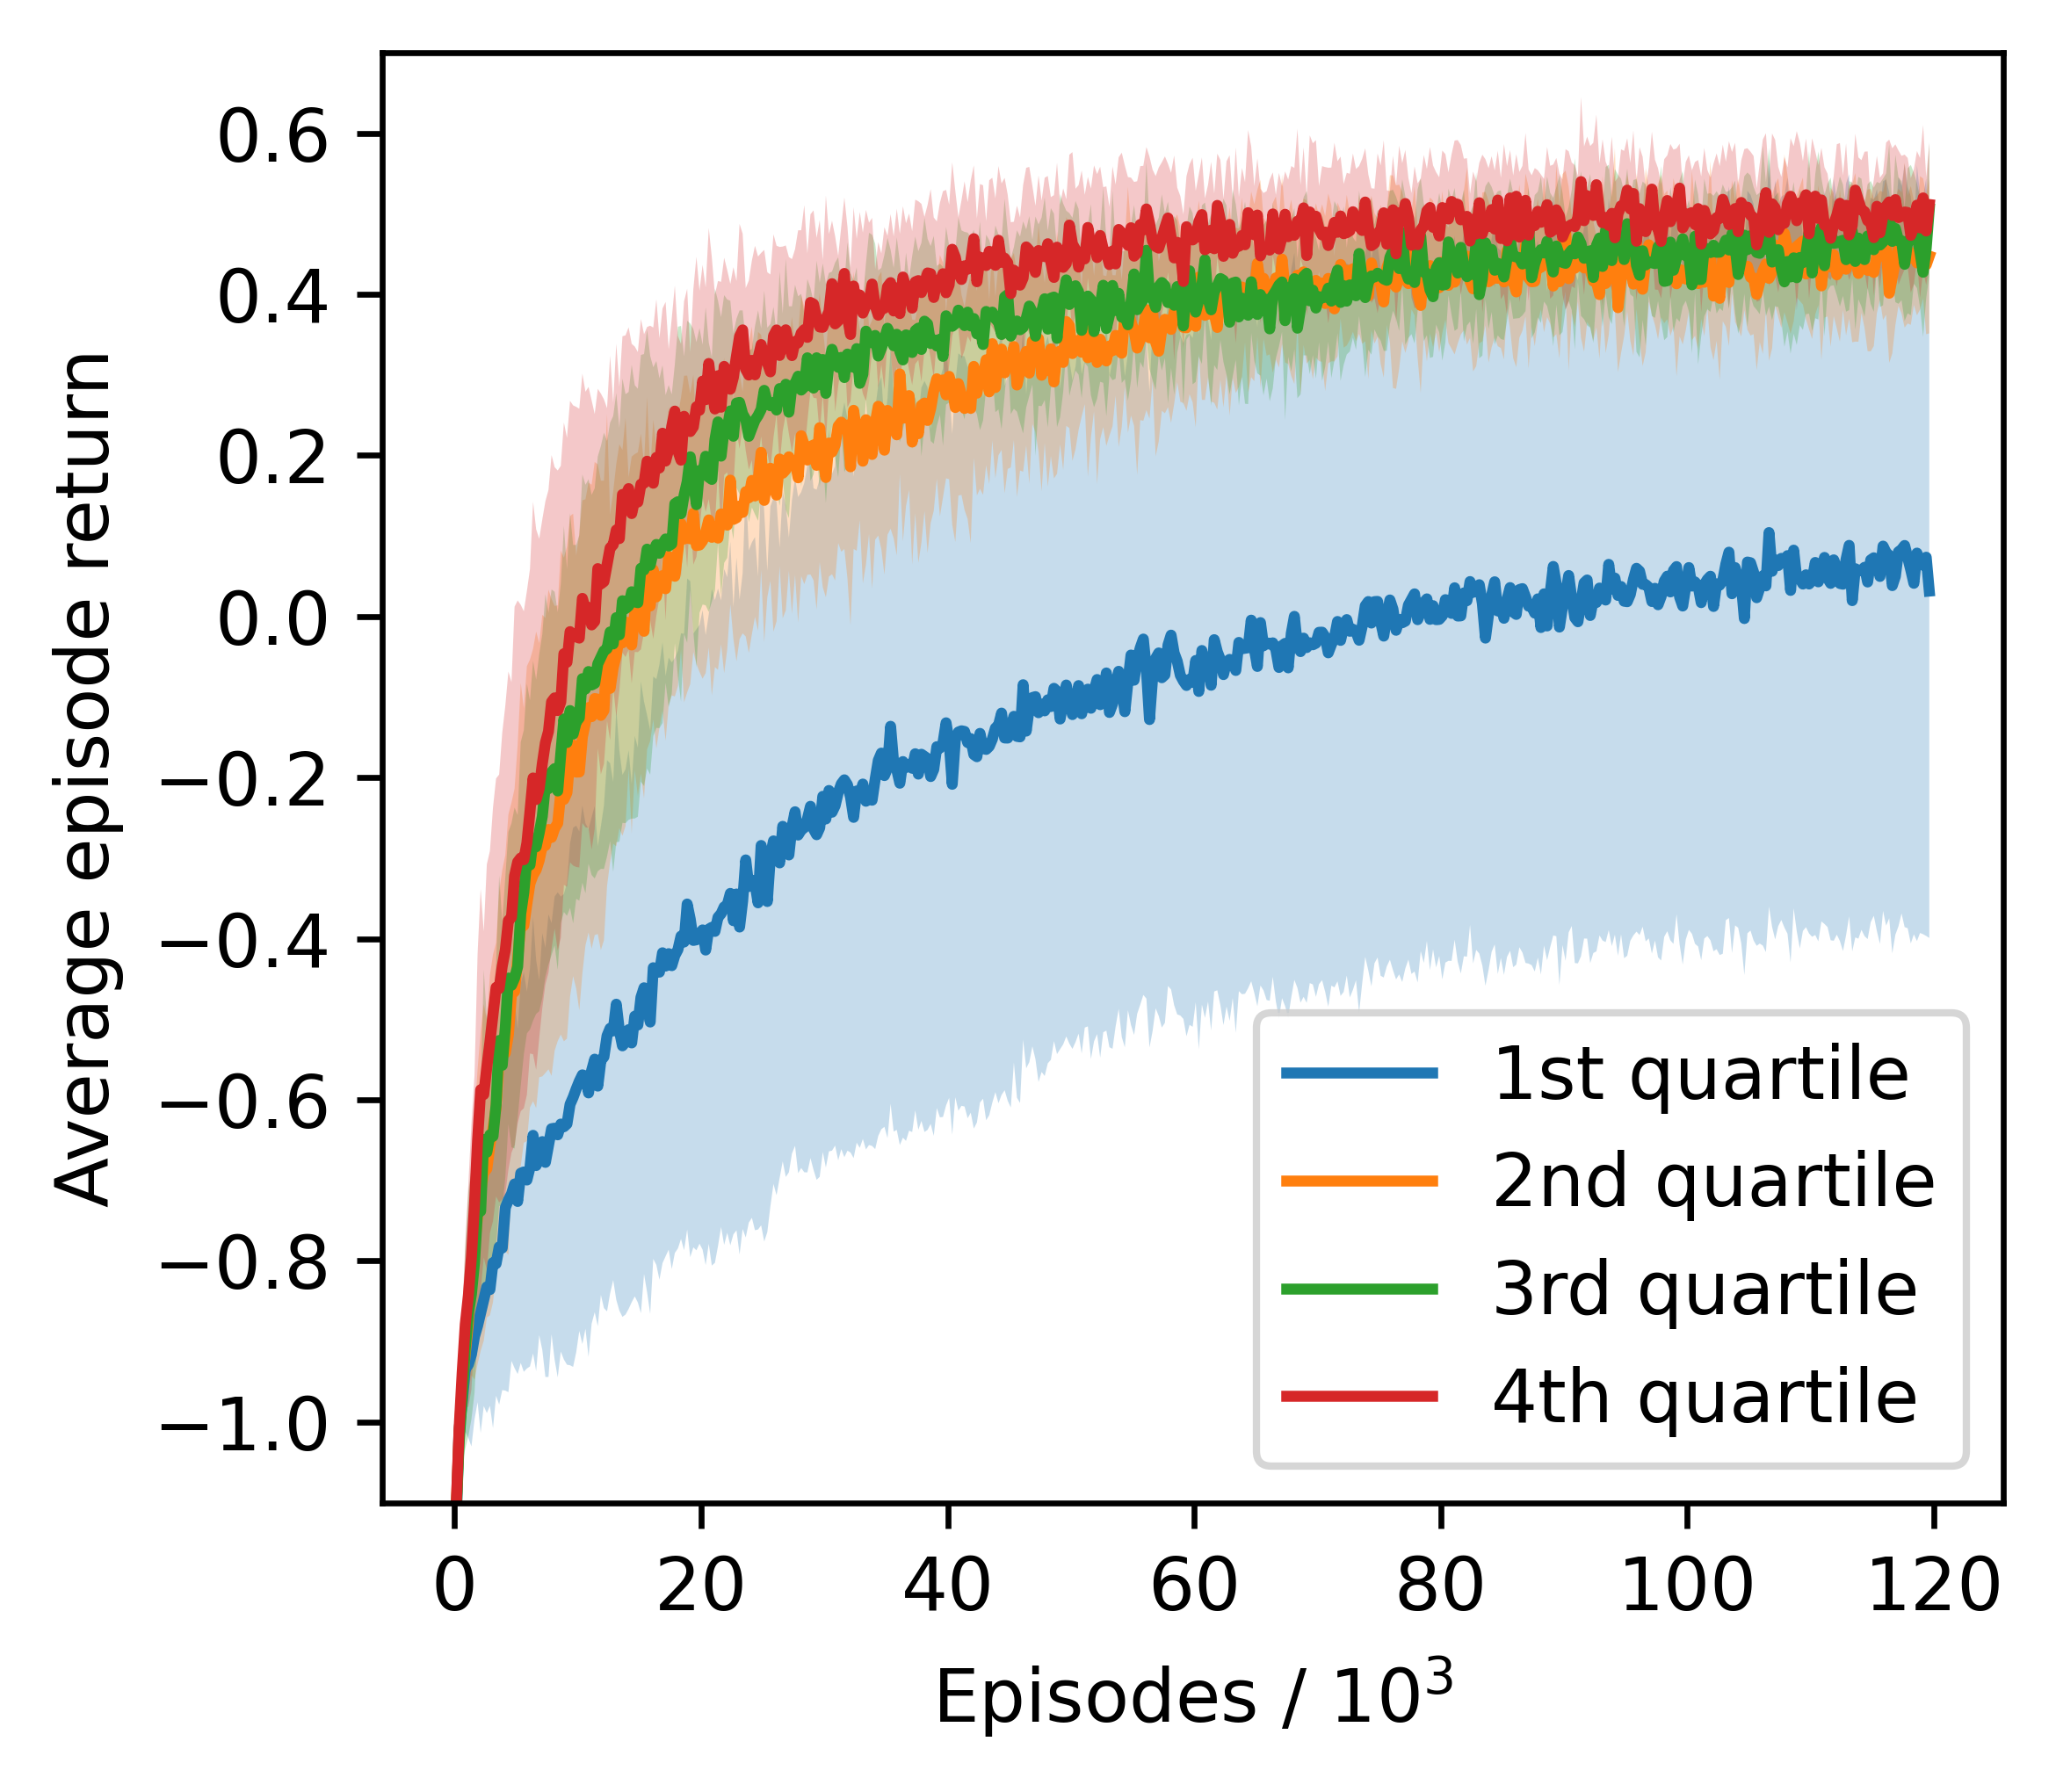

In [7]:
timestamp = ["26-04-24_17-01", "26-04-24_17-04"]
rewards, episodes = load_rewards_vector(timestamp=timestamp, sort=True, min_sr=0.0)

eps = episodes / 1e3

subplot = False
if subplot:
  fig, axs = plt.subplots(1, 2)
else:
  figs = []
  axs = []
  for i in range(2):
    f, a = plt.subplots(1, 1)
    figs.append(f)
    axs.append(a)

# first plot has overall average
avg = np.average(rewards, axis=0)
lstd = avg - np.std(rewards, axis=0)
ustd = avg + np.std(rewards, axis=0)
axs[0].plot(eps, avg, label="average")
axs[0].fill_between(eps, lstd, ustd, alpha=0.25, label="std dev.")

# second plot has quartiles
labels = ["1st quartile", "2nd quartile", "3rd quartile", "4th quartile"]
split = 15
for i in range(int(60/split)):
  avg = np.average(rewards[i*split:(i+1)*split+1], axis=0)
  lstd = avg - np.std(rewards[i*split:(i+1)*split+1], axis=0)
  ustd = avg + np.std(rewards[i*split:(i+1)*split+1], axis=0)
  axs[1].plot(eps, avg, label=labels[i])
  axs[1].fill_between(eps, lstd, ustd, alpha=0.25)

for i in range(len(axs)):
  axs[i].legend(loc="lower right")
  axs[i].set_ylabel("Average episode return")
  axs[i].set_xlabel(r"Episodes / $10^{3}$")
  axs[i].set_ybound(lower=-1.1, upper=0.7)
  if not subplot:
    figs[i].set_size_inches(5*0.8, 3.5*1.0)
    figs[i].tight_layout()
    if True and overwrite: figs[i].savefig(save_path + f"training_spread_return_{i+1}.png")

if subplot:
  fig.set_size_inches(5*(len(axs)), 3.5)
  fig.tight_layout()
  if False and overwrite: fig.savefig(save_path + f"training_spread_return_subplot.png")

In [14]:
TrainingRun = namedtuple("TrainingRun", ("label", "timestamp", "maxval", "jobs"))

# thesis baseline
ppo_EI1 = TrainingRun("EI1", "26-04-24_17-01", 0.924, list(range(1, 21))) # job=4
ppo_EI2 = TrainingRun("EI2", "26-04-24_17-01", 0.931, list(range(21, 41))) # job=31
ppo_EI3 = TrainingRun("EI3", "05-09-24_17-58", 0.903, list(range(21, 31))) # job=48

# main algorithm and baseline runs
ppo_run = TrainingRun("PPO", "26-04-24_17-01", 0.931, list(range(1, 16))) # should be 0.924??
dqn_run = TrainingRun("DQN", "18-06-24_09-54", 0.821, list(range(1, 16)))
ddqn_run = TrainingRun("DDQN", "05-07-24_15-50", 0.819, list(range(1, 16)))
ppo_mat = TrainingRun("PPO-mat", "09-04-24_17-04", 0.918, list(range(1, 16)))
shaped_mat = TrainingRun("MAT+ours", "10-04-24_13-51", 0.809, list(range(16, 31)))
full_mat = TrainingRun("MAT", "08-04-24_17-27", 0.944, list(range(1, 31)))

# PPO trainings compare (PPO-clip is same as PP0)
ppo_clip = TrainingRun("PPO-clip", "26-04-24_17-01", 0.931, list(range(1, 16)))
ppo_pen = TrainingRun("PPO-pen", "06-09-24_15-38", 0.877, list(range(15, 31)))
ppo_ent = TrainingRun("PPO-ent", "05-09-24_10-07", 0.885, list(range(46, 61)))

# operator PC trainings
network_1 = TrainingRun("1 Layer", "05-09-24_17-58", 0.915, list(range(1, 11)))
network_2 = TrainingRun("2 Layers", "05-09-24_17-58", 0.917, list(range(11, 21)))
network_4 = TrainingRun("4 Layers", "26-04-24_17-04", 0.931, list(range(41, 61)))
network_8 = TrainingRun("8 Layers", "05-09-24_17-58", 0.903, list(range(21, 31)))

# reward function compare, changing finger forces
sparse_reward = TrainingRun("Sparse", "01-05-24_13-41", 0.0, list(range(1, 11)))
soft_reward = TrainingRun("Forces 0.5-2.0N", "01-05-24_13-41", 0.867, list(range(11, 21)))
medium_reward = TrainingRun("Forces 0.5-3.0N", "01-05-24_13-41", 0.921, list(range(21, 31)))
hard_reward = TrainingRun("Forces 1.0-3.0N", "01-05-24_13-41", 0.884, list(range(31, 41)))
normal_reward = TrainingRun("Forces 1.0-4.0N", "26-04-24_17-01", 0.924, list(range(1, 11)))

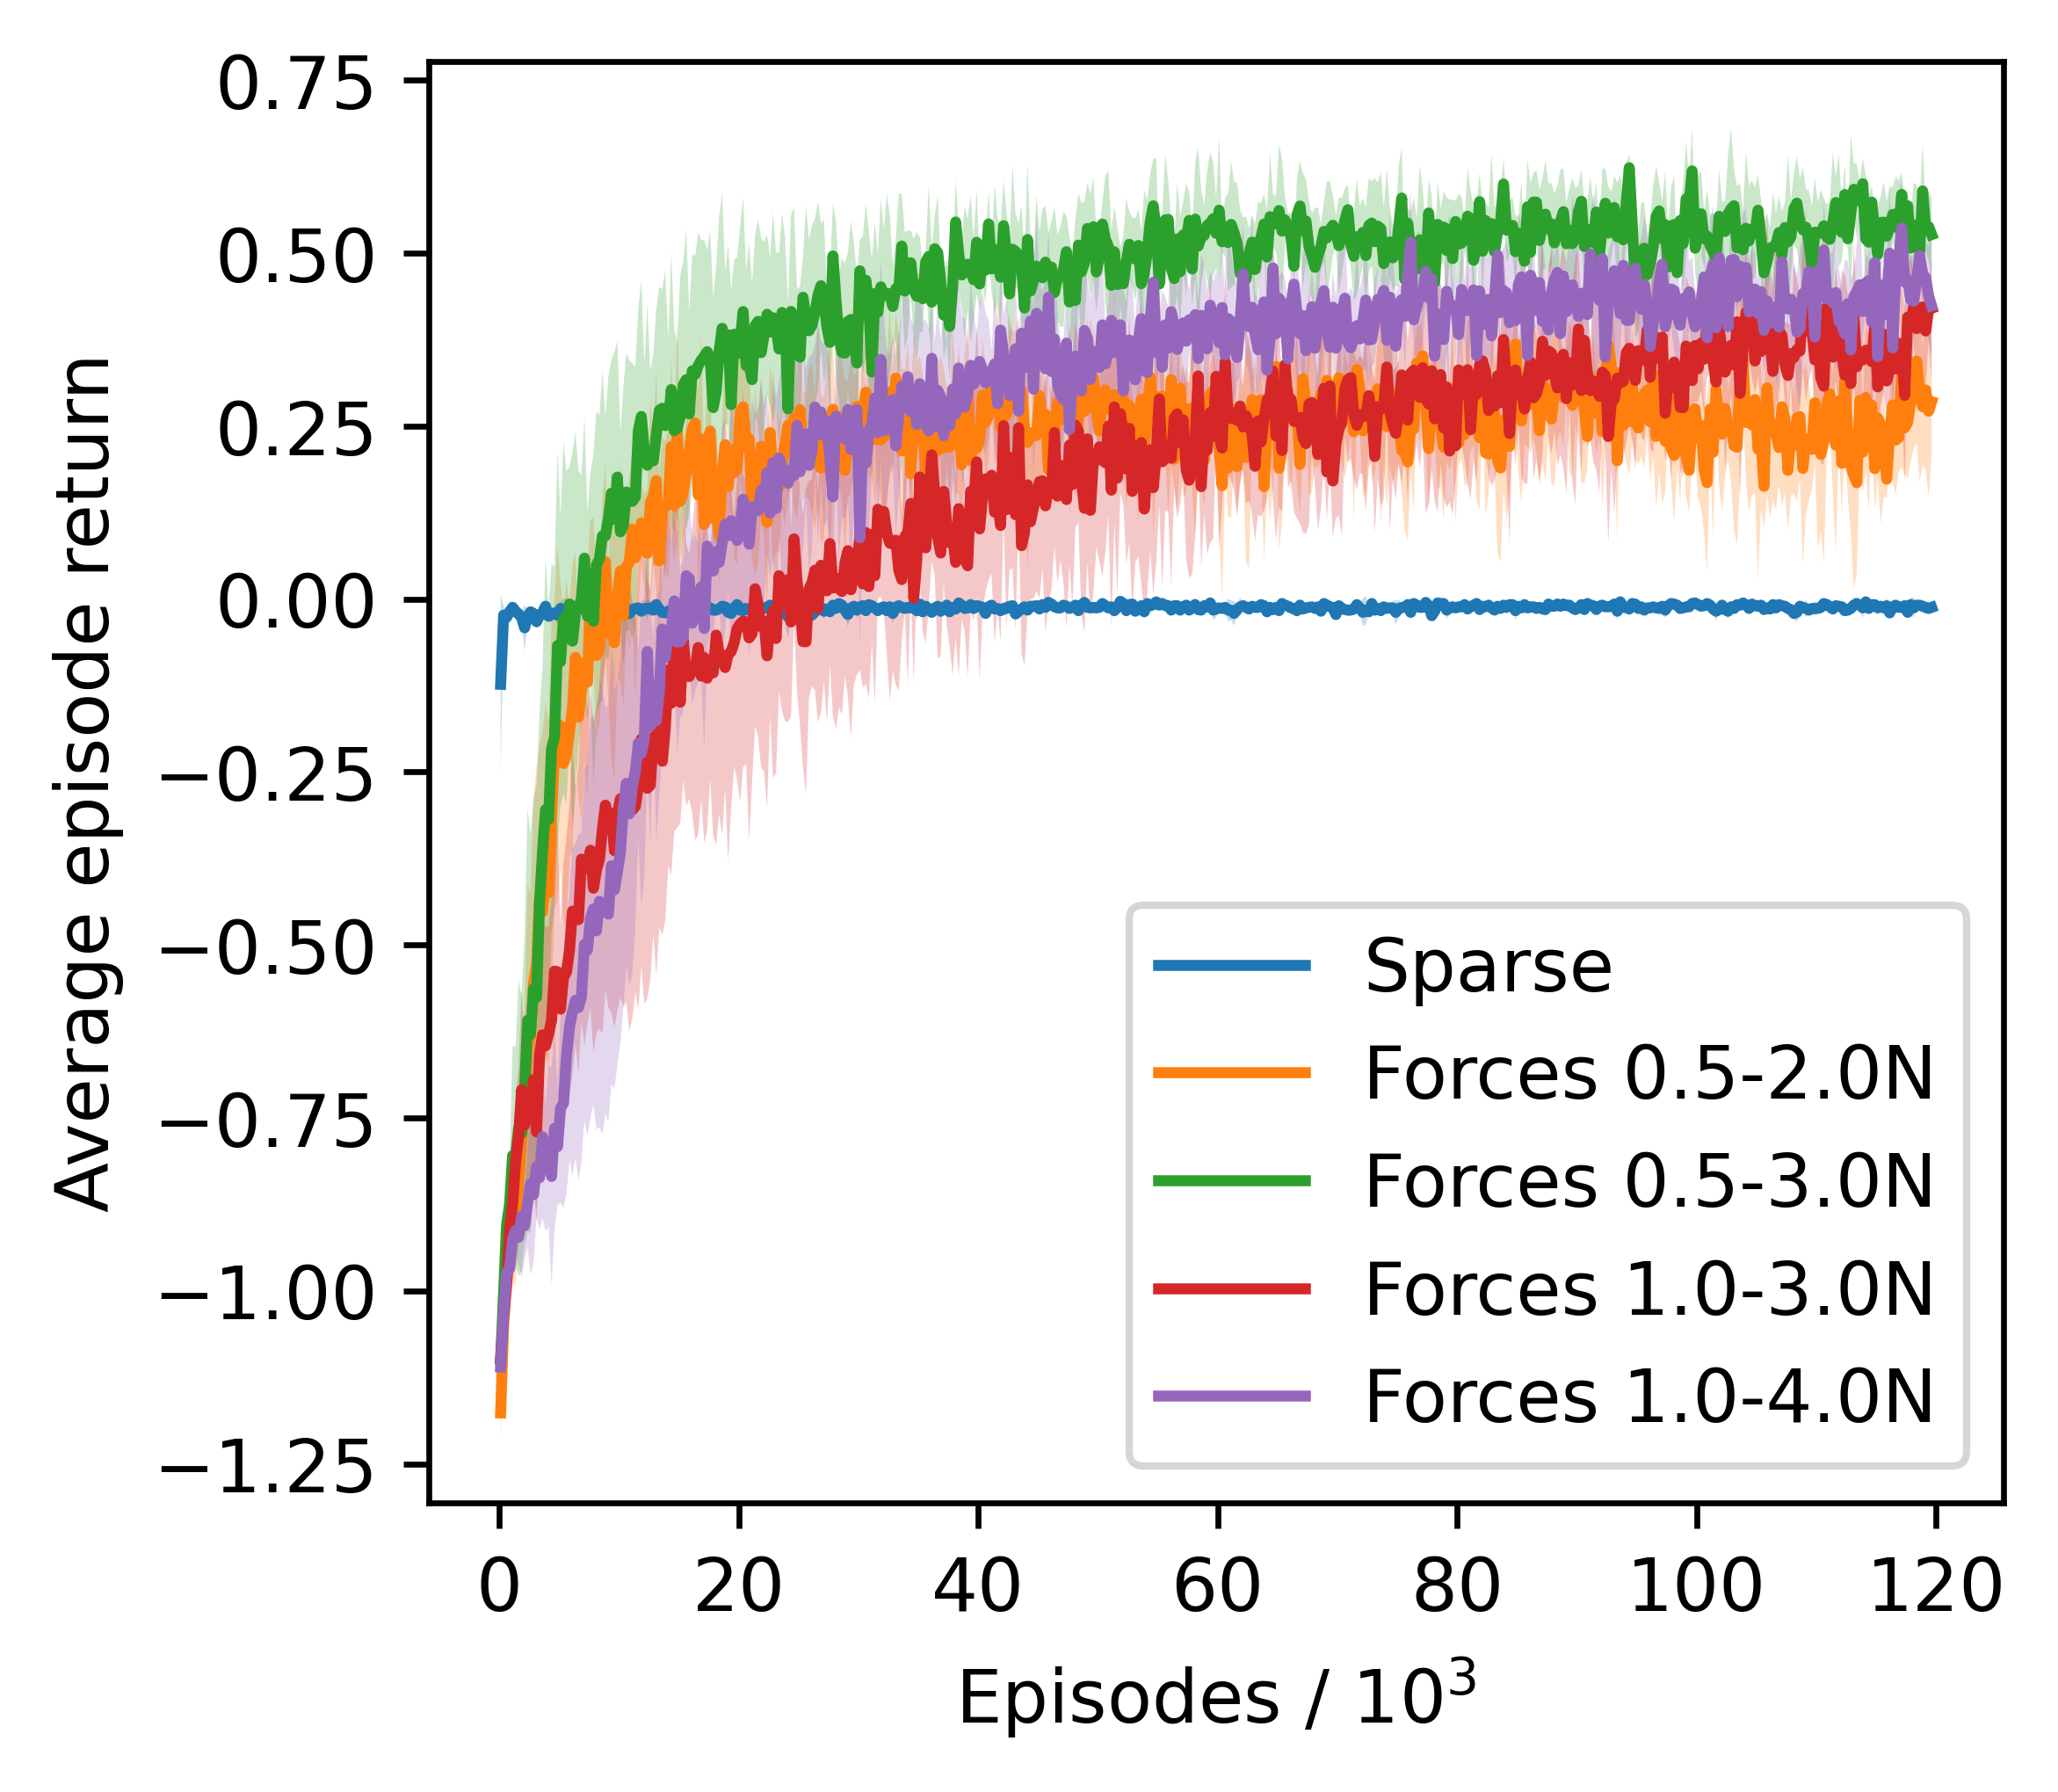

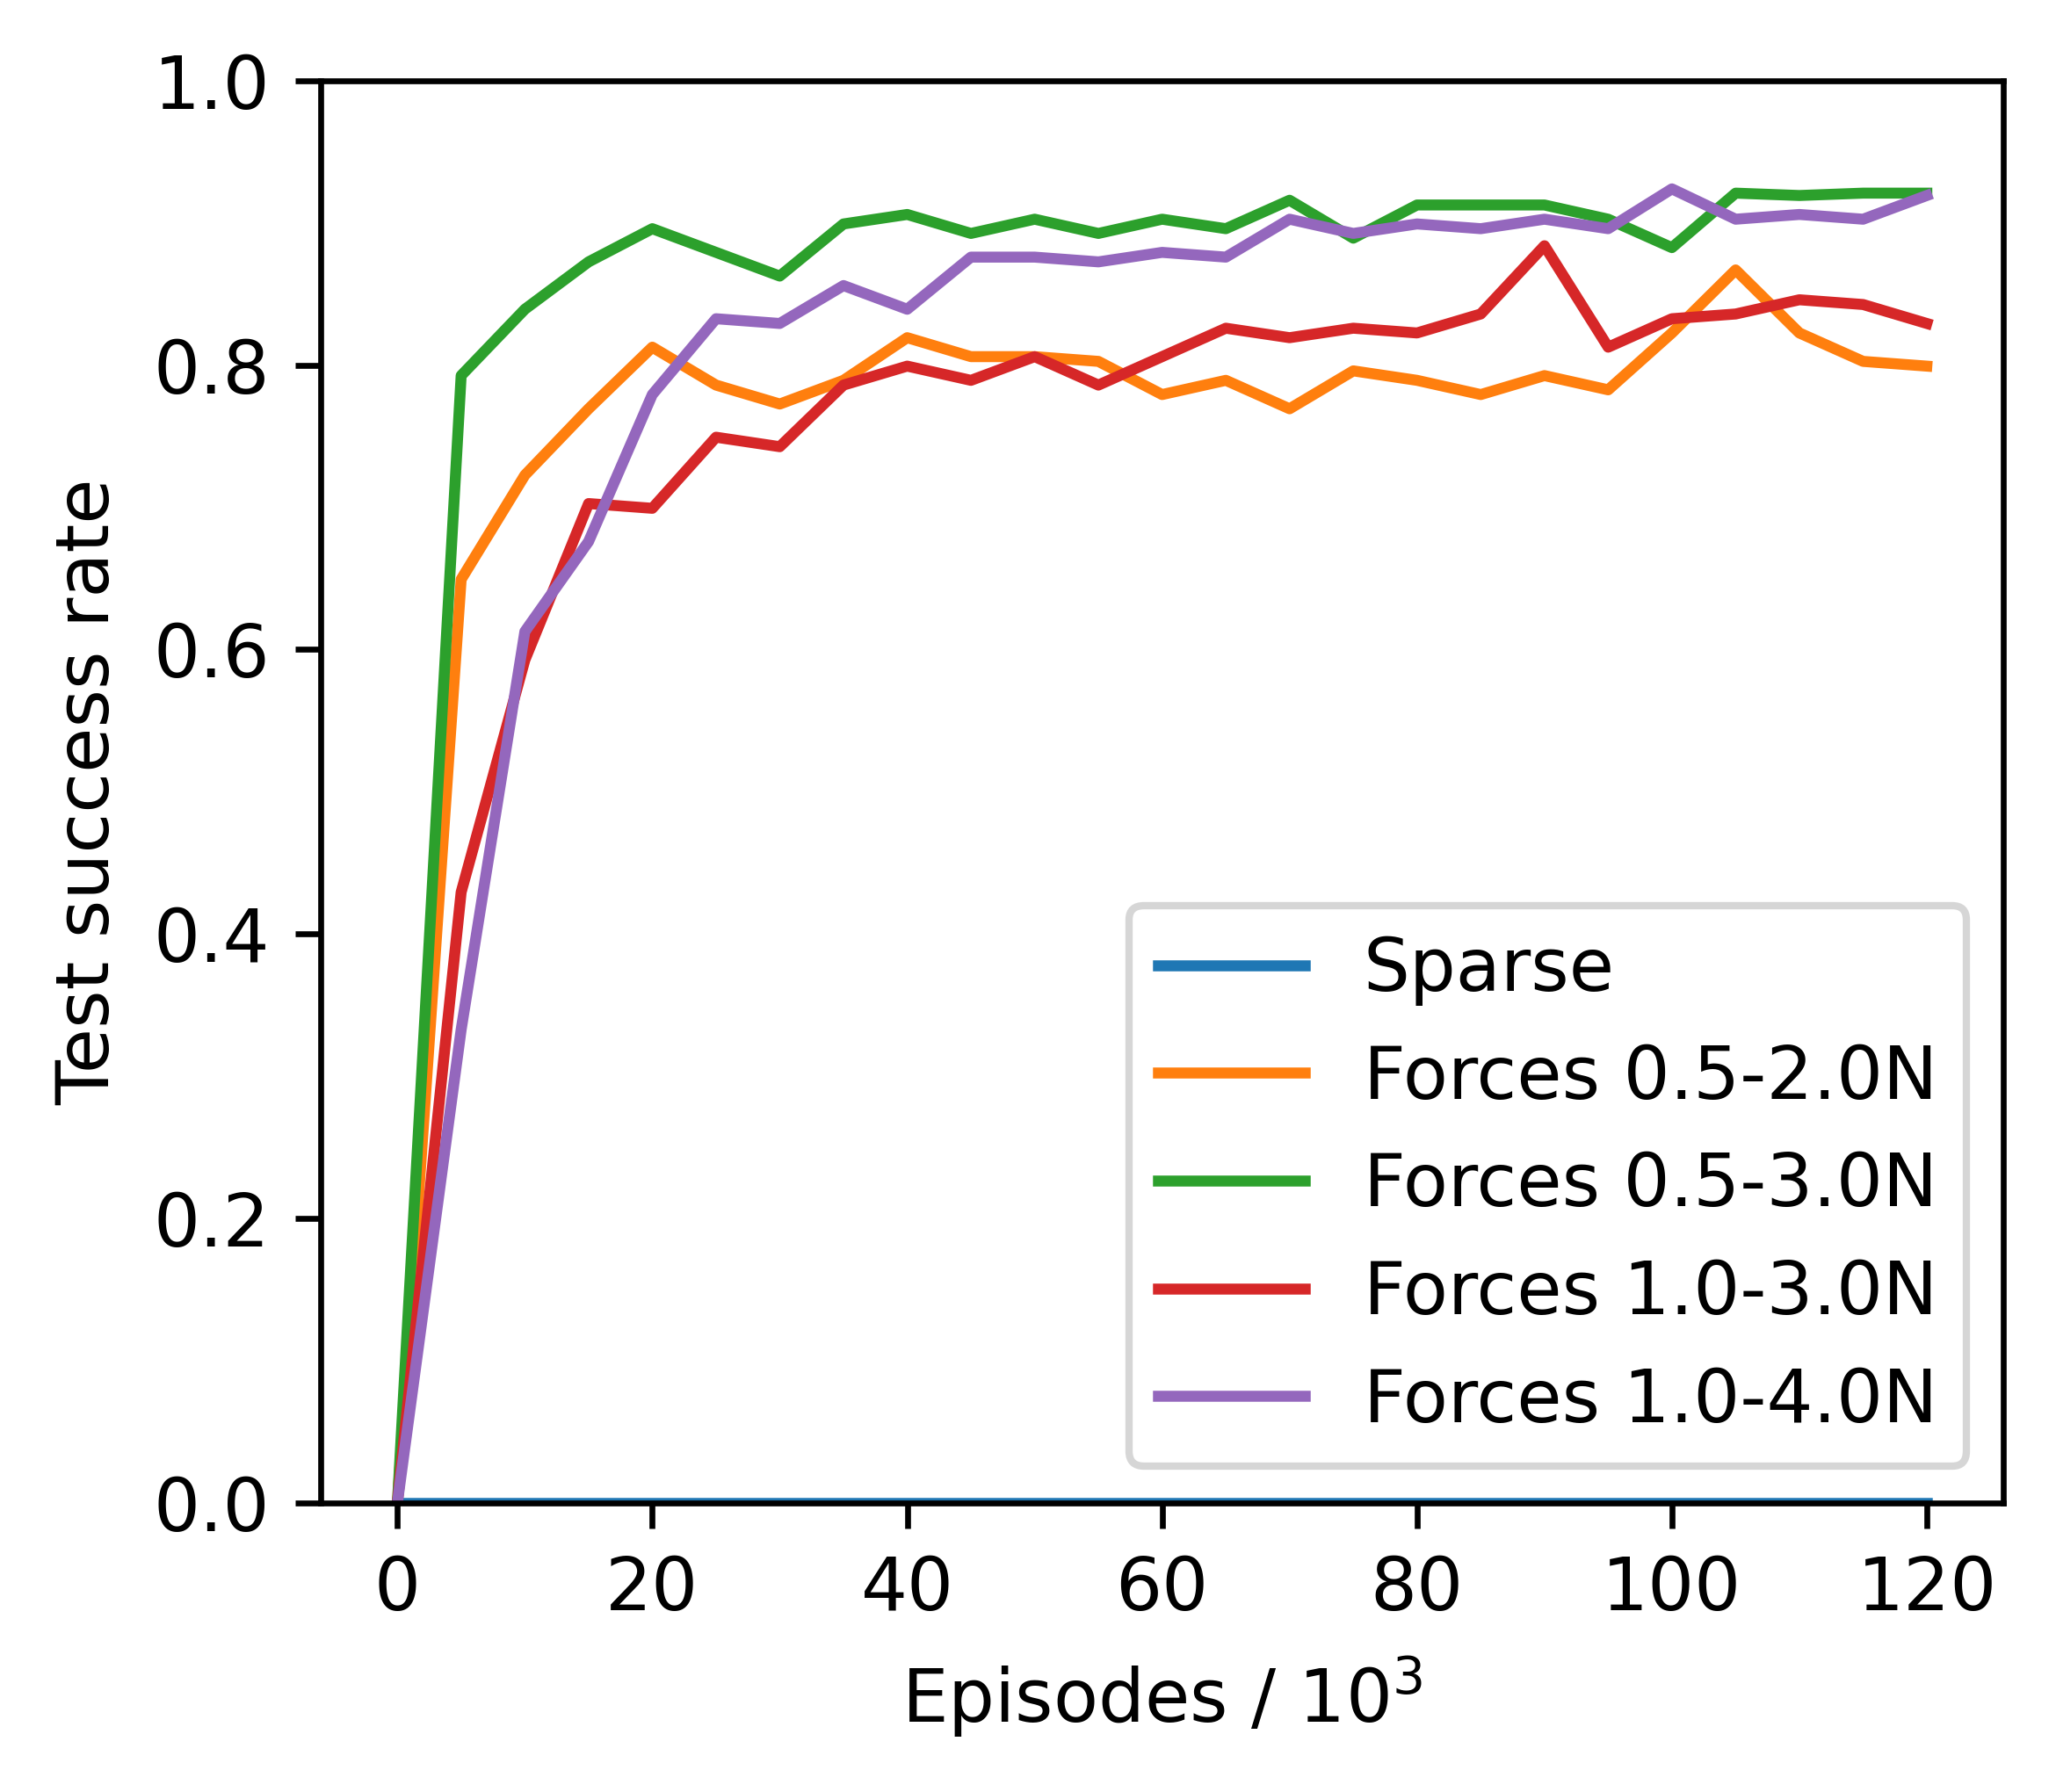

In [15]:
def plot_rewards_results(run_list, top_half=False, save=False, savename="plot_reward_results", 
                         subplot=False, plot_heuristic=False, set9_to_8=False):
  """
  Plot a subplot containing two graphs, one of training rewards, and one of test time
  performance
  """

  if subplot:
    fig, axs = plt.subplots(1, 2)
  else:
    fig1, ax1 = plt.subplots(1, 1)
    fig2, ax2 = plt.subplots(1, 1)
    figs = [fig1, fig2]
    axs = [ax1, ax2]

  for i in range(len(run_list)):

    rewards, episodes = load_rewards_vector(run_list[i].timestamp, jobs=run_list[i].jobs, sort=True, 
                                            name=run_list[i].label, trim=False)
    eps = episodes / 1e3

    results, test_episodes = load_test_results_vector(run_list[i].timestamp, jobs=run_list[i].jobs, sort=True, 
                                            name=run_list[i].label, trim=False)
    t_eps = test_episodes / 1e3

    # first plot has overall average
    if top_half:
      s1 = int(len(rewards) / 2)
      rewards = rewards[s1:]

    # get the average performance
    avg, stddev = tolerant_mean(rewards)

    # trim episodes in case we lost the longest
    eps = eps[:len(avg)]

    # special case: scale MAT to match the other trainings
    if run_list[i].label == "MAT": 
      avg *= 2
      avg -= 1

    # plot the average and the standard deviation
    axs[0].plot(eps, avg, label=run_list[i].label)
    axs[0].fill_between(eps, avg - stddev, avg + stddev, alpha=0.25)

    # second plot has the test time performance
    if top_half:
      s1 = int(len(results) / 2)
      results = results[s1:]
    maxs = tolerant_max(results)
    if set9_to_8:
      # convert to easier object set, ensuring to clip at the maximum actual measured value
      maxs += 0.106
      maxs = np.clip(maxs, 0.0, run_list[i].maxval)
      maxind = np.argmax(maxs)
      maxs[maxind] = run_list[i].maxval
    t_eps = t_eps[:len(maxs)]
    t_eps = np.insert(t_eps, 0, 0)
    maxs = np.insert(maxs, 0, 0)
    axs[1].plot(t_eps, maxs, label=run_list[i].label)

  # are we also plotting heuristic performance
  if plot_heuristic:
    axs[0].plot([0, 120], [0.19, 0.19], "--", label="Heuristic")
    axs[1].plot([0, 120], [0.720, 0.720], "--", label="Heuristic")

  # add labels and formatting
  for i in range(len(axs)):
    axs[i].legend(loc="lower right")
    axs[i].set_ylabel("Average episode return")
    axs[i].set_xlabel(r"Episodes / $10^{3}$")
    if i == 1:
      axs[1].set_ybound(lower=0.0, upper=1.0)
      axs[1].set_ylabel("Test success rate")
    if not subplot:
      figs[i].set_size_inches(5*0.8, 3.5*1.0)
      figs[i].tight_layout()
      if save and overwrite: figs[i].savefig(save_path + f"{savename}_{i+1}.png")

  if subplot:
    fig.set_size_inches(5*(len(axs)), 3.5)
    fig.tight_layout()
    if save and overwrite: fig.savefig(save_path + f"{savename}.png")

# # compare algorithms for main method
# algo_compare_list = [ppo_clip, ppo_pen, ppo_ent, dqn_run, ddqn_run]
# plot_rewards_results(algo_compare_list, top_half=True, save=True, savename="algorithm_compare", 
#                      subplot=False, set9_to_8=True)

# # compare baselines
# baseline_list = [ppo_run, full_mat, shaped_mat]
# plot_rewards_results(baseline_list, top_half=True, save=True, savename="baseline_compare", 
#                      plot_heuristic=True, set9_to_8=True)

# # compare network performance
# networks_list = [network_1, network_2, network_4, network_8]
# plot_rewards_results(networks_list, top_half=True, save=False, savename="baseline_compare", 
#                      set9_to_8=True)

# compare reward functions
networks_list = [sparse_reward, soft_reward, medium_reward, hard_reward, normal_reward]
plot_rewards_results(networks_list, top_half=True, save=False, savename="baseline_compare", 
                     set9_to_8=True)

Text(0, 0.5, 'Test success rate')

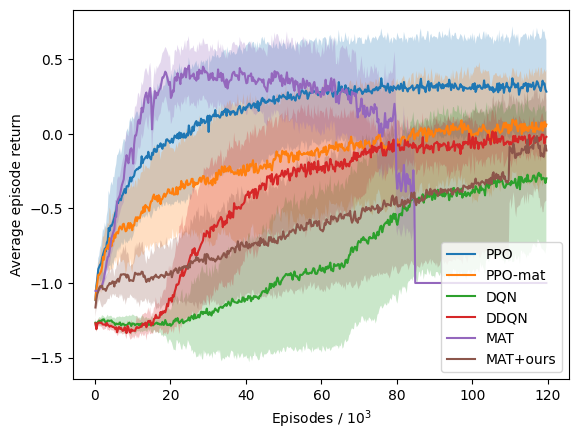

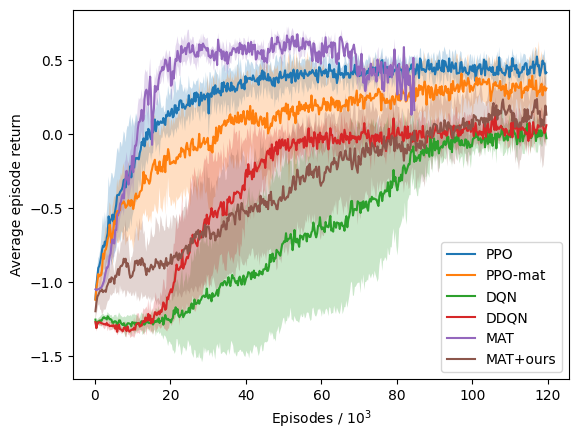

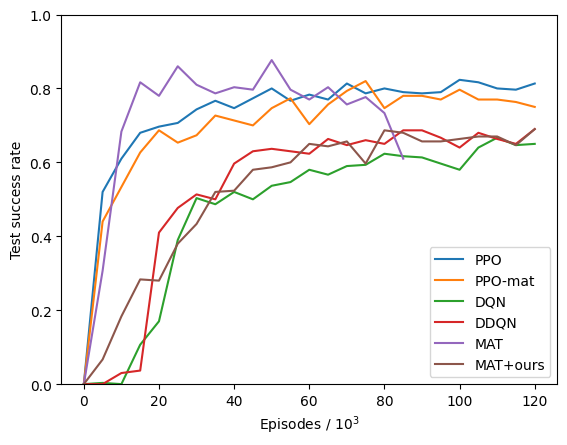

In [9]:
# timestamp = ["26-04-24_17-01", "18-06-24_09-54", "05-07-24_15-50", "09-04-24_17-04", "10-04-24_13-51"]
# rewards, episodes = load_rewards_vector(timestamp=timestamp, sort=True, min_sr=0.0)

# ppo_rewards, ppo_episodes = load_rewards_vector(timestamp=timestamp[0], jobs=list(range(1, 16)), sort=True)
# dqn_rewards, dqn_episodes = load_rewards_vector(timestamp=timestamp[1], jobs=None, sort=True)

# # double dqn, 1=no soft target update, 2=soft target update (worse)
# ddqn_rewards, ddqn_episodes = load_rewards_vector(timestamp=timestamp[2], jobs=list(range(1, 16)), sort=True)
# ddqn2_rewards, ddqn2_episodes = load_rewards_vector(timestamp=timestamp[2], jobs=list(range(16, 31)), sort=True)

# # shaped MAT
# ppo_mat_rewards, ppo_mat_episodes = load_rewards_vector(timestamp=timestamp[3], jobs=list(range(1, 16)), sort=True)
# shaped_mat_rewards, shaped_mat_episodes = load_rewards_vector(timestamp=timestamp[4], jobs=list(range(16, 31)), sort=True)

run_list = [ppo_run, ppo_mat, dqn_run, ddqn_run, full_mat, shaped_mat]

# all_rewards = [ppo_rewards, dqn_rewards, ddqn_rewards, ppo_mat_rewards, shaped_mat_rewards]
# all_episodes = [ppo_episodes, dqn_episodes, ddqn_episodes, ppo_mat_episodes, shaped_mat_episodes]
# labels = ["PPO", "DQN", "DDQN", "PPO-mat", "MAT+ours"]

fig, axs = plt.subplots(1, 1)
fig2, axs2 = plt.subplots(1, 1)
fig3, axs3 = plt.subplots(1, 1) # add test performances?

for i in range(len(run_list)):

  rewards, episodes = load_rewards_vector(run_list[i].timestamp, jobs=run_list[i].jobs, sort=True, 
                                          name=run_list[i].label, trim=False)
  eps = episodes / 1e3

  results, test_episodes = load_test_results_vector(run_list[i].timestamp, jobs=run_list[i].jobs, sort=True, 
                                          name=run_list[i].label, trim=False)
  t_eps = test_episodes / 1e3

  # first plot has overall average
  # avg = np.average(rewards, axis=0)
  # lstd = avg - np.std(rewards, axis=0)
  # ustd = avg + np.std(rewards, axis=0)
  # axs.plot(eps, avg, label=run_list[i].label)
  # axs.fill_between(eps, lstd, ustd, alpha=0.25)

  avg, stddev = tolerant_mean(rewards)

  if run_list[i].label == "MAT": 
    avg *= 2
    avg -= 1

  axs.plot(eps, avg, label=run_list[i].label)
  axs.fill_between(eps, avg - stddev, avg + stddev, alpha=0.25)

  # plot median upwards on other plot
  # s1 = 8
  # s2 = 16
  # avg = np.average(rewards[s1:s2], axis=0)
  # lstd = avg - np.std(rewards[s1:s2], axis=0)
  # ustd = avg + np.std(rewards[s1:s2], axis=0)
  # axs2.plot(eps, avg, label=labels[i])
  # axs2.fill_between(eps, lstd, ustd, alpha=0.25)

  s1 = int(len(rewards) / 2) + 1
  rewards_median_up = rewards[s1:]

  avg, stddev = tolerant_mean(rewards_median_up)

  # trim episodes in case we lost the longest
  eps = eps[:len(avg)]

  if run_list[i].label == "MAT": 
    avg *= 2
    avg -= 1

  axs2.plot(eps, avg, label=run_list[i].label)
  axs2.fill_between(eps, avg - stddev, avg + stddev, alpha=0.25)

  s1 = int(len(results) / 2) + 1
  results_median_up = results[s1:]
  maxs = tolerant_max(results_median_up)
  t_eps = t_eps[:len(maxs)]
  t_eps = np.insert(t_eps, 0, 0)
  maxs = np.insert(maxs, 0, 0)
  axs3.plot(t_eps, maxs, label=run_list[i].label)
  # axs3.fill_between(t_eps, avg - stddev, avg + stddev, alpha=0.25)

axs = [axs, axs2, axs3]

for i in range(len(axs)):
  axs[i].legend(loc="lower right")
  axs[i].set_ylabel("Average episode return")
  axs[i].set_xlabel(r"Episodes / $10^{3}$")
  # axs[i].set_ybound(lower=-1.1, upper=0.7)
  # if not subplot:
  #   figs[i].set_size_inches(5*0.8, 3.5*0.8)
  #   figs[i].tight_layout()
  #   if False and overwrite: figs[i].savefig(save_path + f"training_spread_return_{i+1}.png")

axs3.set_ybound(lower=0.0, upper=1.0)
axs3.set_ylabel("Test success rate")

# if subplot:
#   fig.set_size_inches(5*(len(axs)), 3.5)
#   fig.tight_layout()
#   if False and overwrite: fig.savefig(save_path + f"training_spread_return_subplot.png")

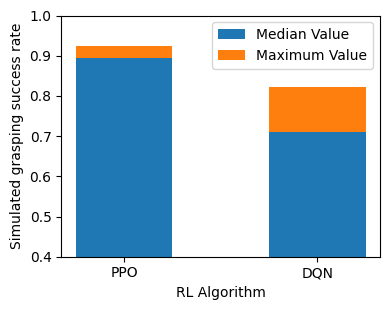

In [10]:
def plot_max_median(labels, medians, maxes, title=None):
  """
  Plot a stacked bar chart of median and max training performance
  """

  weight_counts = {
      "Median Value": np.array(medians),
      "Maximum Value": np.array(maxes) - np.array(medians),
  }
  width = 0.5

  fig, ax = plt.subplots()
  bottom = np.zeros(len(labels))

  for boolean, weight_count in weight_counts.items():
      p = ax.bar(labels, weight_count, width, label=boolean, bottom=bottom)
      bottom += weight_count

  if title is not None:
     ax.set_title("Number of penguins with above average body mass")
  ax.legend(loc="upper right")

  ax.set_ylabel("Simulated grasping success rate")
  ax.set_ylim(bottom=0.4, top=1.0)
  fig.set_size_inches(5*0.8, 4*0.8)
  fig.tight_layout()

  return fig, ax

labels = ["PPO", "DQN"]
medians = [
  0.895,
  0.709
]
maxes = [
  0.924,
  0.821
]

fig1, ax1 = plot_max_median(labels, medians, maxes)

ax1.set_xlabel("RL Algorithm")
fig1.tight_layout()

if False and overwrite: 
  fig1.savefig(save_path + "stiffness_pilot.png")

/home/luke/pyenv/py38_general/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/luke/pyenv/py38_general/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/luke/pyenv/py38_general/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/luke/pyenv/py38_general/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/luke/pyenv/py38_general/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


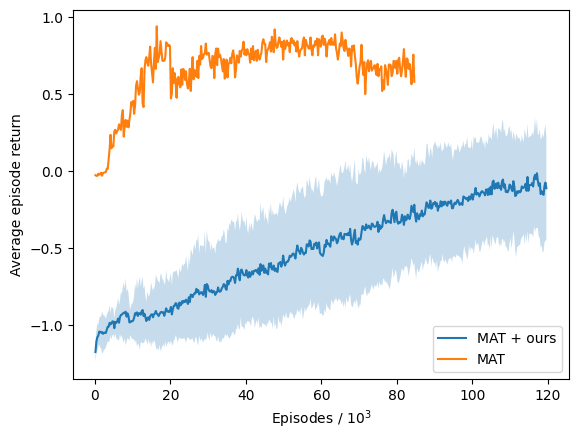

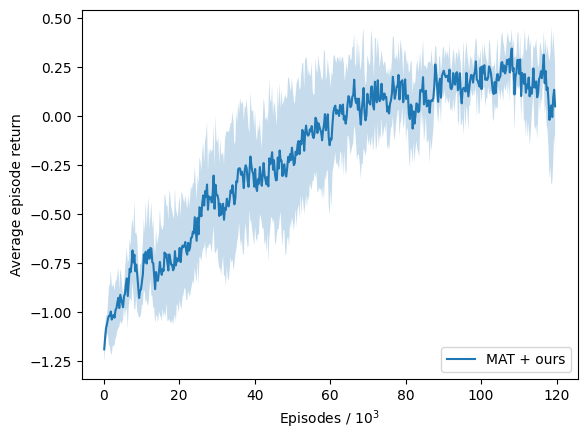

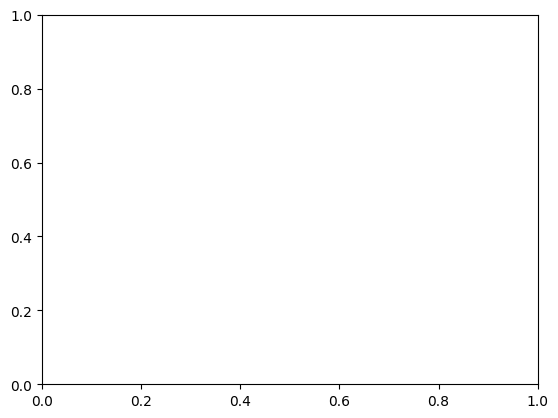

In [11]:
timestamp = ["10-04-24_13-51", "08-04-24_17-27"]
rewards, episodes = load_rewards_vector(timestamp=timestamp, sort=True, min_sr=0.0)

shaped_mat_rewards, shaped_mat_episodes = load_rewards_vector(timestamp=timestamp[0], jobs=list(range(16, 31)), sort=True)
mat_rewards, mat_episodes = load_rewards_vector(timestamp=timestamp[1], jobs=list(range(1, 21)), sort=True)

all_rewards = [shaped_mat_rewards, mat_rewards]
all_episodes = [shaped_mat_episodes, mat_episodes]
labels = ["MAT + ours", "MAT"]

fig, axs = plt.subplots(1, 1)
fig2, axs2 = plt.subplots(1, 1)
fig3, axs3 = plt.subplots(1, 1) # add test performances?

for i in range(len(all_rewards)):

  rewards = all_rewards[i]
  eps = all_episodes[i] / 1e3

  # first plot has overall average
  avg = np.average(rewards, axis=0)
  lstd = avg - np.std(rewards, axis=0)
  ustd = avg + np.std(rewards, axis=0)
  axs.plot(eps, avg, label=labels[i])
  axs.fill_between(eps, lstd, ustd, alpha=0.25)

  # plot median upwards on other plot
  s1 = 8
  s2 = 16
  avg = np.average(rewards[s1:s2], axis=0)
  lstd = avg - np.std(rewards[s1:s2], axis=0)
  ustd = avg + np.std(rewards[s1:s2], axis=0)
  try:
    axs2.plot(eps, avg, label=labels[i])
    axs2.fill_between(eps, lstd, ustd, alpha=0.25)
  except: pass

axs = [axs, axs2]

for i in range(len(axs)):
  axs[i].legend(loc="lower right")
  axs[i].set_ylabel("Average episode return")
  axs[i].set_xlabel(r"Episodes / $10^{3}$")
  # axs[i].set_ybound(lower=-1.1, upper=0.7)
  # if not subplot:
  #   figs[i].set_size_inches(5*0.8, 3.5*0.8)
  #   figs[i].tight_layout()
  #   if False and overwrite: figs[i].savefig(save_path + f"training_spread_return_{i+1}.png")

# if subplot:
#   fig.set_size_inches(5*(len(axs)), 3.5)
#   fig.tight_layout()
#   if False and overwrite: fig.savefig(save_path + f"training_spread_return_subplot.png")